In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Tensorflow imports
from keras import layers

# Image processing
import glob
import PIL
import matplotlib.pyplot as plt

In [3]:
folder = '/content/drive/MyDrive/CS 271/'

# We temporarily use a single malware family
malware_folder = 'malimg_paper_dataset_imgs/Adialer.C/'

How, we load our images. Not all images are 410$\times$512, and we can now convert the images to numpy arrays and make up missing values.

In [4]:
image_list = []
path = os.path.join(folder, malware_folder, '*.png')
for filename in glob.glob(path):
  with PIL.Image.open(filename) as im:
    im_arr = np.array(im.resize((512, 512)))
    im_arr.resize((512, 512))
    image_list.append(im_arr)

We have loaded all of our images that we need. All images are 512$\times$512, and we can now convert the images to numpy arrays.

In [5]:
dataset = np.array(image_list)
dataset.shape

(122, 512, 512)

In [6]:
train_images = dataset.reshape(dataset.shape[0], 512, 512, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 10

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Building the GAN

Now that we have all matters related to the dataset taken care of, we can begin building the GAN structure.

In [9]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 512)))
    assert model.output_shape == (None, 8, 8, 512)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(4, 4), padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(4, 4), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 512, 512, 1)

    return model

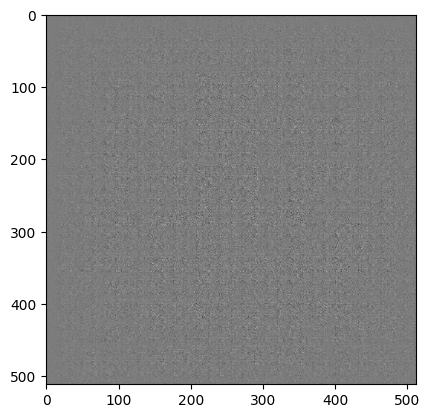

In [10]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (5, 5), strides=(4, 4), padding='same',
                                     input_shape=[512, 512, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(4, 4), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [12]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[1.8132574e-05]], shape=(1, 1), dtype=float32)


# Defining the Training Process

In [13]:
generator_loss_history = []
discriminator_loss_history = []
accuracy_history = []

We define our loss functions.

In [14]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [16]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

We define our accuracy function.

In [17]:
accuracy_tracker = tf.keras.metrics.BinaryAccuracy()

In [18]:
def update_accuracy(real_output, fake_output):
  accuracy_tracker.update_state(tf.ones_like(real_output), real_output)
  accuracy_tracker.update_state(tf.zeros_like(fake_output), fake_output)

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

In [20]:
EPOCHS = 1000
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [21]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      update_accuracy(real_output, fake_output)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [22]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    total_gen_loss = 0
    total_disc_loss = 0

    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
      total_gen_loss += gen_loss
      total_disc_loss += disc_loss

    generator_loss_history.append(total_gen_loss / len(dataset))
    discriminator_loss_history.append(total_disc_loss / len(dataset))

    # Get accuracy and reset
    accuracy_history.append(accuracy_tracker.result())
    accuracy_tracker.reset_state()

    # Produce images for the GIF as you go
    if (epoch % 20 == 0):
      generate_and_save_images(generator,
                              epoch + 1,
                              seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [23]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.show()

# Training

Now we are ready to train the GAN.

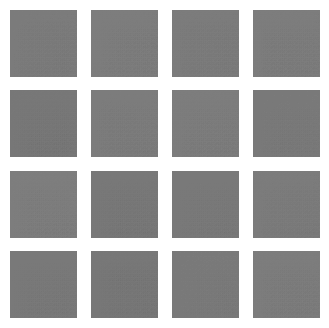

Time for epoch 1 is 32.23127889633179 sec
Time for epoch 2 is 24.289331912994385 sec


In [ ]:
train(train_dataset, EPOCHS)

# Testing

We can attempt to generate an image and compare it to a real malware sample.

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
decision = discriminator(generated_image)
print(decision)

In [ ]:
image = train_images[0:1]
plt.imshow(image[0, :, :, 0], cmap='gray')

In [ ]:
decision = discriminator(image)
print(decision)

Now, we can plot the loss history to assess convergence.

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss (Generator)', color=color)
ax1.plot(generator_loss_history, color=color, alpha=0.6)

ax2 = ax1.twinx()

color = 'tab:orange'
ax2.set_ylabel('Loss (Discriminator)', color=color)
ax2.plot(discriminator_loss_history, color=color, alpha=0.6)

fig.tight_layout()
plt.show()

In [ ]:
def get_rounded_accuracy(epochs):
  rounded_accuracies = []
  for index in range(len(accuracy_history) - epochs):
    average_accuracy = sum(accuracy_history[index:index + epochs]) / epochs
    rounded_accuracies.append(average_accuracy)

  return rounded_accuracies

In [ ]:
average_range = 20

plt.plot(accuracy_history, label='Accuracy')
plt.plot(range(average_range, len(accuracy_history)),
         get_rounded_accuracy(average_range),
         label=f'Average Accuracy in Past {average_range} Epochs')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Discriminator Accuracy')
plt.show()